# "Standard Candle" MNIST Toy 1: Plain Vanilla MNIST

This is a basic pytorch-based MNIST training and evaluation pipeline with no fundamental changes yet. However, changes have been made to ensure that random number generation is deterministic, and that we shut down our connection to the GPU at the end to prevent notebook collisions.

Note that this notebook should be run from the `notebooks/` subdirectory.

## Setup

In [122]:
# NOTE: Change this to what the notebook name is for each experiment to ensure
# training results are saved into the right sub-directory.
notebook_name = '01b_simple_toy1'

import random

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [123]:
results_path = os.path.join('../../training_results', notebook_name)
model_path = os.path.join(results_path, 'model.pth')
optimizer_path = os.path.join(results_path, 'optimizer.pth')

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
# TODO: Change to second order optimizer like ADAM.
learning_rate = 0.01
momentum = 0.5
log_interval = 10

mnist_global_mean = 0.1307
mnist_std = 0.3081

In [75]:
cuda_device = 0
torch.backends.cudnn.enabled = True
if not torch.cuda.is_available():
  raise RuntimeError("CUDA not available! Unable to continue")
# Force ourselves to use only one GPU.
device = torch.device("cuda:0")
print("Using device {} for training, current device: {}, total devices: {}".format(
  device, torch.cuda.current_device(), torch.cuda.device_count()))

random_seed = 1
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using device cuda:0 for training, current device: 0, total devices: 6


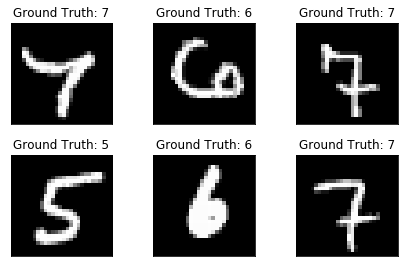

In [76]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../../data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (mnist_global_mean,), (mnist_std,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

# TODO: See if setting num_workers > 1 or using pin_memory can help with CPU/GPU transfers.
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../../data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (mnist_global_mean,), (mnist_std,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# TODO: By default the backgrounds are black and the text is white; invert this.

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)
    return F.log_softmax(x)

network = Net()
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses, train_counter, test_losses = [], [], []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data)
    output = output.to(device)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100.0 * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
      torch.save(network.state_dict(), model_path)
      torch.save(optimizer.state_dict(), optimizer_path)

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      output = output.to(device)
      # TODO: Handle the deprecation warning for log_softmax needing an explicit 'dim' argument
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100.0 * correct / len(test_loader.dataset)))

## Do the actual training

In [77]:
def time_wrapper():
  test()
  for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

%time time_wrapper()

/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.278279
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.279660
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.263016
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.256685
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.301191
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.188858
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.181756
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.072378
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.031334
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.080950
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.935666
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.736406
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.910163
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.754839
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.444749
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.503208
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.324583
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.444610
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.301197
Train Epoch: 1 [12160/6

Text(0, 0.5, 'negative log likelihood loss')

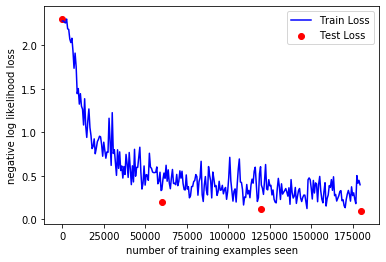

In [78]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## Inference Example With Trained Network

In [79]:
with torch.no_grad():
  output = network(example_data.to(device))
  output = output.cpu()

/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


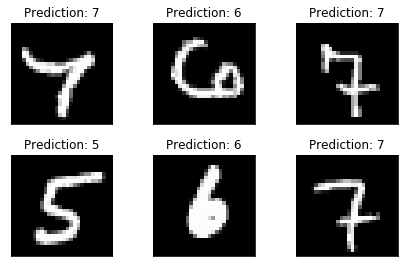

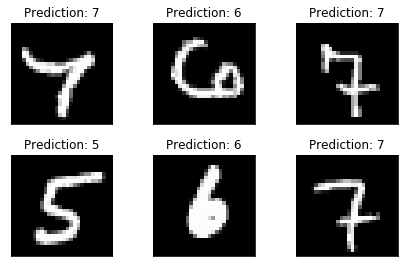

In [80]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Continue Training From Saved Checkpoint &amp; Final Training Results

In [84]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

network_state_dict = torch.load(model_path)
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load(optimizer_path)
continued_optimizer.load_state_dict(optimizer_state_dict)

In [86]:
def continue_training():
  for i in range(4, 9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()

%time continue_training()

/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/conda/envs/wmlce_py3_sdo/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.123470
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.257010
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.100009
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.129411
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.149332
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.085749
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.230743
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.158438
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.116088
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.283592
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.142472
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.178194
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.667661
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.378450
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.234468
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.291433
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.169165
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.148089
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.418636
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.287298
Train Epoch: 4 [12800/60000 (

Text(0, 0.5, 'negative log likelihood loss')

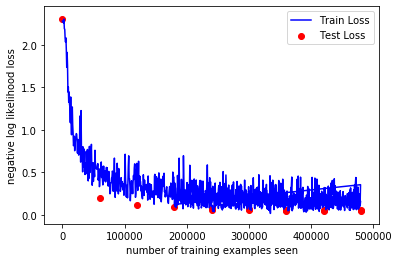

In [128]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## Final Best Results

### Test set: Avg. loss: 0.0469, Accuracy: 9848/10000 (98%)

## Cleanup

In [ ]:
# Force the GPU connection to close so that Jupyter sessions don't collide with each other.
device = torch.device("cpu")